## Setup

In [25]:
!pip install https://github.com/parulsethi/SMorph/releases/download/0.1.0/SMorph-0.1.0.tar.gz

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Created wheel for smorph: filename=SMorph-0.1.0-py3-none-any.whl size=21006 sha256=9c144a2279e0d5f2798966221a89e2157b40e264f7103d9eb2d9e280569f5a5c
  Stored in directory: c:\users\kushaan gupta\appdata\local\pip\cache\wheels\75\83\8e\c51ddbdc81445e5f7d1670d8d1000a54680c18ee03c7611b0a
Successfully built smorph


In [26]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
import smorph as sm
import skimage
import matplotlib.pyplot as plt

In [28]:
def plot(image):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.imshow(image)
    ax.set_axis_off()
    plt.show()

## Start single cell analysis

In [29]:
# path to a cell image (relative to Smorph folder) 
cell_image = skimage.io.imread("Datasets/CTRLvsSTAB/control/MAX_SW MICE 1_SEC 1_GFAP_RIGHT_CA1 _CONTRA_1-2_3.tif")

In [30]:
astrocyte = sm.Cell(cell_image, image_type='confocal')

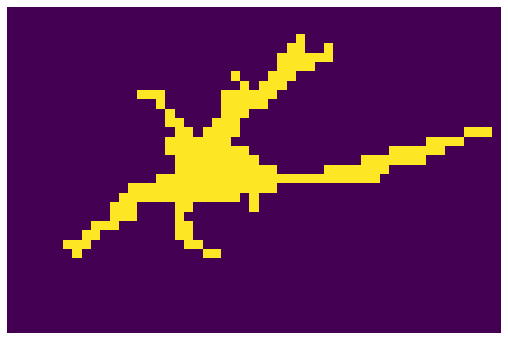

In [31]:
plot(astrocyte.cleaned_image)

In [32]:
astrocyte.features

{'surface_area': 196,
 'total_length': 87,
 'avg_process_thickness': 2.3,
 'convex_hull': 635,
 'no_of_forks': 5,
 'no_of_primary_branches': 4,
 'no_of_secondary_branches': 6,
 'no_of_tertiary_branches': 2,
 'no_of_quatenary_branches': 0,
 'no_of_terminal_branches': 8,
 'avg_length_of_primary_branches': 6.0,
 'avg_length_of_secondary_branches': 9.3,
 'avg_length_of_tertiary_branches': 2.5,
 'avg_length_of_quatenary_branches': 0,
 'avg_length_of_terminal_branches': 8.0,
 'critical_radius': 6,
 'critical_value': 4.73,
 'enclosing_radius': 27,
 'ramification_index': 1.18,
 'skewness': -0.17,
 'coefficient_of_determination': 0.98,
 'sholl_regression_coefficient': 0.16,
 'regression_intercept': -1.11}

In [33]:
astrocyte.features['surface_area']

196

## Skeleton Analysis

In [34]:
# Sum of highlighted pixels is calculated to get the skeleton area estimate
astrocyte.features['total_length']

87

In [35]:
# Sum of highlighted pixels is calculated to get the area estimate of astrocyte
astrocyte.features['avg_process_thickness']

2.3

635

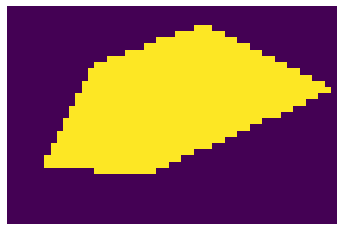

In [36]:
# Sum of pixels included in the smallest convex polygon that surround all astrocyte pixels
astrocyte.plot_convex_hull()
astrocyte.features['convex_hull']

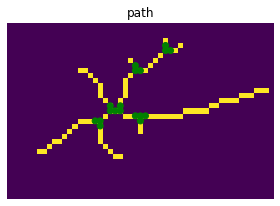

5

In [37]:
# Count all the bifurcation points
astrocyte.plot_forks()
astrocyte.features['no_of_forks']

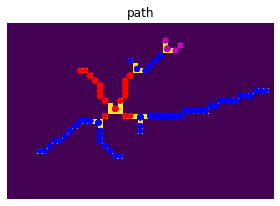

In [38]:
# The branches are differentiated into primary, secondary and further levels to compare any branch level differences between astrocytes
astrocyte.plot_branching_structure()

## Sholl Analysis

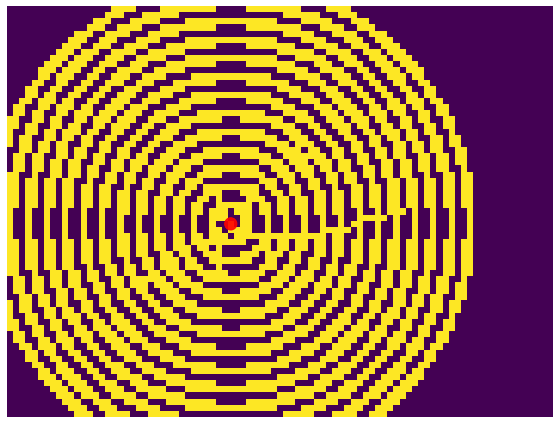

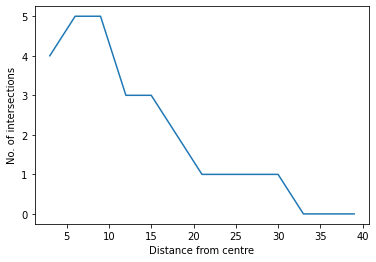

In [39]:
# Number of intersections of astrocytic branches at regular distances from the soma
astrocyte.plot_sholl_results()

Polynomial regression is used to mitigate the influence of local variations in the sampled data, and thereby better describe the relationship between intersections vs. distance

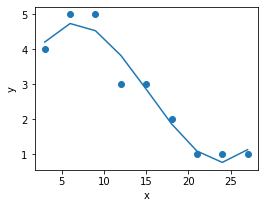

In [40]:
astrocyte.plot_polynomial_fit()

In [41]:
# Distance at which Critical value occurs (distance at which the Highest count of intersections occurred)
astrocyte.features['critical_radius']

6

In [42]:
# # Local maximum of the polynomial fit (Maximum no. of intersections)
astrocyte.features['critical_value']

4.73

In [43]:
# The last (thus, the widest) of intersecting radii to be associated with the number of intersections
astrocyte.features['enclosing_radius']

27

In [44]:
# Indication of how symmetrical the distribution is around its mean
astrocyte.features['skewness']

-0.17

In [45]:
# Ratio between critical value and number of primary branches
astrocyte.features['ramification_index']

1.18

In [46]:
# how close the data are to the fitted regression (indicative of the level of explained variability in the data set)
astrocyte.features['coefficient_of_determination']

0.98

In [47]:
# Rate of decay of no. of branches
astrocyte.features['sholl_regression_coefficient']

0.16

In [48]:
# Y intercept of the logarithmic plot
astrocyte.features['regression_intercept']

-1.11